# t-SNE Visualisation of CNN features

### Imports

In [66]:
import os

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision import utils

from torchsummary import summary

### Utils

In [40]:
def imshow(img):
    '''
    display tensor as image
    '''
    img = utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [71]:
def get_intermediate_output(model, x, device):
    '''
    returns a torch tensor obtained as output from average pool of resnet
    '''
    # use 'device'
    model.to(device)
    x = x.to(device)
    
    model.eval()
    
    # create hooks
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output
        return hook
    
    handle = model.avgpool.register_forward_hook(get_activation('avgpool'))
    
    # get features
    _ = model(x)
    features = activation['avgpool'].reshape(-1,512)
    handle.remove()
    
    return features

### Load Model

In [2]:
model = models.resnet18(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print()

In [24]:
img = torch.randn(1,3,244,244)

In [25]:
img.shape

torch.Size([1, 3, 244, 244])

In [26]:
get_intermediate_output(model, img, device)

torch.Size([512])


### Get Feature Embeddings

In [49]:
root = 'imagenette2/val'

In [60]:
# imagenet transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((224,224)),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])

In [61]:
dataset = ImageFolder(root,transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [62]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


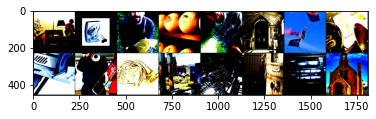

In [63]:
imshow(images)

In [79]:
# gets feature embeddings for the average pool layer and saves it in a .tsv file 
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        avgpool_output = get_intermediate_output(model, images, device)
        avgpool_output = avgpool_output.cpu().numpy()
        labels = labels.numpy().reshape(-1,1)
        
        df_features = pd.DataFrame(avgpool_output)
        df_features.to_csv('vis.tsv', mode='a', header=False, sep='\t', index=False)
        df_labels = pd.DataFrame(labels)
        df_labels.to_csv('metadata.tsv', mode='a', header=False, sep='\t', index=False)